# 암환자 유전체 데이터 기반 암종 분류 AI 모델 개발

- 참고 : https://dacon.io/competitions/official/236355/codeshare/11610?page=1&dtype=recent

- 암환자 유전체 데이터의 변이 정보를 활용하여 암종을 분류하는 AI 모델을 개발
- 암환자 유전체 변이 정보을 사용하여 특정 변이 정보를 바탕으로 암종을 정확하게 분류할 수 있는 AI 알고리즘을 개발


- **ID**
  - 환자 또는 데이터 샘플의 고유 식별자
  - 예를 들어, `TRAIN_0000`은 첫 번째 환자를 나타냅니다.
- **SUBCLASS**
  - 해당 환자의 암종
  - 예를 들어, `KIPAN`, `SARC`, `SKCM` 등은 다양한 암종을 나타냄
- **유전자 정보(A2M, AAAS, AADAT 등)**
  - 유전자 이름을 나타내며, 각 열은 해당 유전자에서 관찰된 변이를 기록
  - 예를 들어, `R895R`과 같은 변이는 특정 위치에서 발생한 유전자 변이를 나타냄
  - 만약 변이가 없다면 "WT"(wild type, 정상형)를 의미

# 0. 데이터 및 라이브러리 불러오기

In [5]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings(action='ignore')

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
!unzip -qq '/content/drive/MyDrive/0000/dacon_biodata/open.zip'

# 1. 데이터 확인

In [26]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
submission = pd.read_csv('sample_submission.csv')

In [9]:
train.head(5)

,ID,SUBCLASS,A2M,AAAS,AADAT,AARS1,ABAT,ABCA1,ABCA2,ABCA3,...,ZNF292,ZNF365,ZNF639,ZNF707,ZNFX1,ZNRF4,ZPBP,ZW10,ZWINT,ZYX
0,TRAIN_0000,KIPAN,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT
1,TRAIN_0001,SARC,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT
2,TRAIN_0002,SKCM,R895R,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT
3,TRAIN_0003,KIRC,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT
4,TRAIN_0004,GBMLGG,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT


In [10]:
test.head(5)

,ID,A2M,AAAS,AADAT,AARS1,ABAT,ABCA1,ABCA2,ABCA3,ABCA4,...,ZNF292,ZNF365,ZNF639,ZNF707,ZNFX1,ZNRF4,ZPBP,ZW10,ZWINT,ZYX
0,TEST_0000,WT,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT
1,TEST_0001,WT,WT,WT,WT,WT,R587Q,WT,WT,WT,...,WT,WT,WT,WT,WT,I383Sfs,WT,WT,WT,WT
2,TEST_0002,WT,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT
3,TEST_0003,WT,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT
4,TEST_0004,WT,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT


## EDA

In [24]:
train.shape, test.shape

((6201, 4386), (2546, 4385))

In [11]:
train.describe(), len(train)

(                ID SUBCLASS   A2M  AAAS AADAT AARS1  ABAT ABCA1 ABCA2 ABCA3  \
 count         6201     6201  6201  6201  6201  6201  6201  6201  6201  6201   
 unique        6201       26   141    43    25     1    48   145   119   129   
 top     TRAIN_6200     BRCA    WT    WT    WT    WT    WT    WT    WT    WT   
 freq             1      786  6053  6157  6176  6201  6153  6045  6079  6069   
 
         ... ZNF292 ZNF365 ZNF639 ZNF707 ZNFX1 ZNRF4  ZPBP  ZW10 ZWINT   ZYX  
 count   ...   6201   6201   6201   6201  6201  6201  6201  6201  6201  6201  
 unique  ...    168     69     33     27   126    61    53    53    35    41  
 top     ...     WT     WT     WT     WT    WT    WT    WT    WT    WT    WT  
 freq    ...   6025   6131   6169   6174  6065  6139  6143  6142  6166  6159  
 
 [4 rows x 4386 columns],
 6201)

In [12]:
train.info

<bound method DataFrame.info of               ID SUBCLASS    A2M AAAS AADAT AARS1 ABAT ABCA1 ABCA2 ABCA3  ...  \
0     TRAIN_0000    KIPAN     WT   WT    WT    WT   WT    WT    WT    WT  ...   
1     TRAIN_0001     SARC     WT   WT    WT    WT   WT    WT    WT    WT  ...   
2     TRAIN_0002     SKCM  R895R   WT    WT    WT   WT    WT    WT    WT  ...   
3     TRAIN_0003     KIRC     WT   WT    WT    WT   WT    WT    WT    WT  ...   
4     TRAIN_0004   GBMLGG     WT   WT    WT    WT   WT    WT    WT    WT  ...   
...          ...      ...    ...  ...   ...   ...  ...   ...   ...   ...  ...   
6196  TRAIN_6196     LUAD     WT   WT    WT    WT   WT    WT    WT    WT  ...   
6197  TRAIN_6197      LGG     WT   WT    WT    WT   WT    WT    WT    WT  ...   
6198  TRAIN_6198     COAD     WT   WT    WT    WT   WT    WT    WT    WT  ...   
6199  TRAIN_6199     TGCT     WT   WT    WT    WT   WT    WT    WT    WT  ...   
6200  TRAIN_6200     SKCM     WT   WT    WT    WT   WT    WT    WT    WT  ...   

     ZNF292 ZNF365 ZNF639 ZNF707 ZNFX1 ZNRF4 ZPBP ZW10  ZWINT ZYX  
0        WT     WT     WT     WT    WT    WT   WT   WT     WT  WT  
1        WT     WT     WT     WT    WT    WT   WT   WT     WT  WT  
2        WT     WT     WT     WT    WT    WT   WT   WT     WT  WT  
3        WT     WT     WT     WT    WT    WT   WT   WT     WT  WT  
4        WT     WT     WT     WT    WT    WT   WT   WT     WT  WT  
...     ...    ...    ...    ...   ...   ...  ...  ...    ...  ..  
6196     WT     WT     WT     WT    WT    WT   WT   WT     WT  WT  
6197     WT     WT     WT     WT    WT    WT   WT   WT     WT  WT  
6198     WT     WT     WT     WT    WT    WT   WT   WT  T181S  WT  
6199     WT     WT     WT     WT    WT    WT   WT   WT     WT  WT  
6200     WT     WT     WT     WT    WT    WT   WT   WT     WT  WT  

[6201 rows x 4386 columns]>

### subclass

In [13]:
train.SUBCLASS.unique()

array(['KIPAN', 'SARC', 'SKCM', 'KIRC', 'GBMLGG', 'STES', 'BRCA', 'THCA',
       'LIHC', 'HNSC', 'PAAD', 'OV', 'PRAD', 'UCEC', 'LAML', 'COAD',
       'ACC', 'LGG', 'LUSC', 'LUAD', 'CESC', 'PCPG', 'THYM', 'BLCA',
       'TGCT', 'DLBC'], dtype=object)

1. **KIPAN**: Kidney Pan-Cancer (다양한 신장암을 포함한 범암종)
2. **SARC**: Sarcoma (육종)
3. **SKCM**: Skin Cutaneous Melanoma (피부 흑색종)
4. **KIRC**: Kidney Renal Clear Cell Carcinoma (신장 신세포 암종)
5. **GBMLGG**: Glioblastoma & Lower Grade Glioma (교모세포종 및 저등급 신경교종)
6. **STES**: Stomach and Esophageal Carcinoma (위 및 식도암)
7. **BRCA**: Breast Cancer (유방암)
8. **THCA**: Thyroid Carcinoma (갑상선암)
9. **LIHC**: Liver Hepatocellular Carcinoma (간세포 암종)
10. **HNSC**: Head and Neck Squamous Cell Carcinoma (두경부 편평세포암)
11. **PAAD**: Pancreatic Adenocarcinoma (췌장 선암)
12. **OV**: Ovarian Cancer (난소암)
13. **PRAD**: Prostate Adenocarcinoma (전립선 선암)
14. **UCEC**: Uterine Corpus Endometrial Carcinoma (자궁내막암)
15. **LAML**: Acute Myeloid Leukemia (급성 골수성 백혈병)
16. **COAD**: Colon Adenocarcinoma (결장 선암)
17. **ACC**: Adrenocortical Carcinoma (부신피질암)
18. **LGG**: Lower Grade Glioma (저등급 신경교종)
19. **LUSC**: Lung Squamous Cell Carcinoma (폐 편평세포암)
20. **LUAD**: Lung Adenocarcinoma (폐 선암)
21. **CESC**: Cervical Squamous Cell Carcinoma and Endocervical Adenocarcinoma (자궁경부암 및 자궁경부 선암)
22. **PCPG**: Pheochromocytoma and Paraganglioma (크롬친화세포종 및 패러강종)
23. **THYM**: Thymoma (흉선종)
24. **BLCA**: Bladder Cancer (방광암)
25. **TGCT**: Testicular Germ Cell Tumors (고환 생식세포 종양)
26. **DLBC**: Diffuse Large B-Cell Lymphoma (미만성 거대 B세포 림프종)

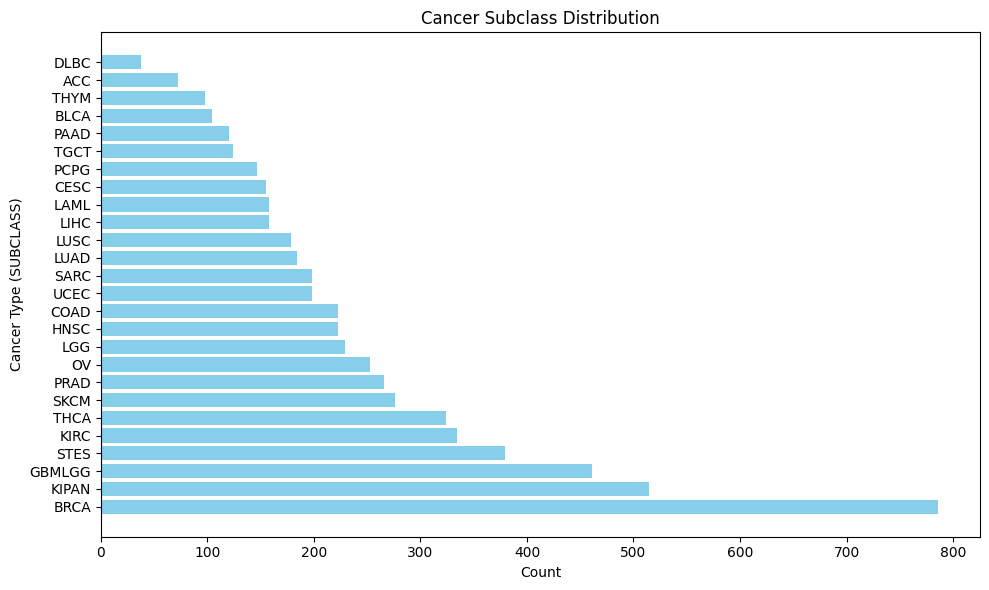

In [14]:
# 암종을 종류별로 확인
df = pd.DataFrame(train.SUBCLASS.value_counts())

plt.figure(figsize=(10, 6))
plt.barh(df.index, df['count'], color='skyblue')
plt.xlabel('Count')
plt.ylabel('Cancer Type (SUBCLASS)')
plt.title('Cancer Subclass Distribution')
plt.tight_layout()

### other columns - 유전자 목록 (Gene List)

In [48]:
# ID와 SUBCLASS를 제외한 train과 test의 열 목록을 추출
train_columns = set(train.drop(columns=['ID', 'SUBCLASS']).columns)
test_columns = set(test.drop(columns=['ID']).columns)

# train에만 있고 test에는 없는 열
diff_in_train = train_columns - test_columns

# test에만 있고 train에는 없는 열
diff_in_test = test_columns - train_columns

# 결과 출력
if diff_in_train:
    print("train 데이터셋에만 있는 열들:", diff_in_train)
else:
    print("train 데이터셋에는 추가적인 열이 없습니다.")

if diff_in_test:
    print("test 데이터셋에만 있는 열들:", diff_in_test)
else:
    print("test 데이터셋에는 추가적인 열이 없습니다.")


train 데이터셋에는 추가적인 열이 없습니다.
test 데이터셋에는 추가적인 열이 없습니다.


### values

전부 다 WT인데 일부가 특정 값이면 subclass 분류 되는데 이렇게 되면 이 규칙을 어떻게 파악하면 좋은지 생각해보는게 좋을지도 ..? >>


TRAIN_0002의 경우, 암종 SKCM과 R895R 변이를 가지고 있습니다. 다른 유전자는 모두 "WT"입니다. 이런 유전적 변이가 SKCM(피부암)과 어떤 연관성이 있는지 모델이 학습하게 됩니다.
TRAIN_0001은 SARC(육종) 암종에 속하며, 모든 유전자가 "WT"로 되어 있습니다. 모델은 이런 패턴도 학습하게 될 것입니다.


In [22]:
train_wt_columns = train.columns[(train == 'WT').all()].tolist()
test_wt_columns = test.columns[(test == 'WT').all()].tolist()

print('데이터셋에서 값이 모두 WT인 열 개수')
print()
print('trainSet: ', len(train_wt_columns))
print('testSet: ', len(test_wt_columns))

데이터셋에서 값이 모두 WT인 열 개수

trainSet:  154
testSet:  26


In [28]:
# 모든 유전자가 WT인 행을 추출
wt_train = train[(train.iloc[:, 2:] == 'WT').all(axis=1)]

# WT 행들의 SUBCLASS 분포 확인
wt_subclass_distribution = wt_train['SUBCLASS'].value_counts()

# 분포 출력
print(wt_subclass_distribution)

SUBCLASS
THYM      30
THCA      18
LAML      12
BRCA       5
KIPAN      4
PRAD       4
SARC       3
CESC       3
LGG        3
PCPG       3
LUSC       2
STES       2
GBMLGG     2
KIRC       2
PAAD       1
Name: count, dtype: int64


TrainSet에서의 94개 행의 라벨 값 분포로는 'THYM' (흉선암)으로 예측하는 것이 합리적

In [21]:
cnt = 0
both_wt_columns = []
for gene in train_wt_columns:
  if gene in test_wt_columns:
    both_wt_columns.append(gene)
    cnt += 1

print('두 데이터셋에서 값이 모두 WT인 열 개수:', cnt)
print()
both_wt_columns

두 데이터셋에서 값이 모두 WT인 열 개수: 21


['BOLA2',
 'CROCCP2',
 'EEIG1',
 'G6PC1',
 'GPX4',
 'H2AC25',
 'HBBP1',
 'HYCC2',
 'MIX23',
 'MYL11',
 'NHERF1',
 'NHERF4',
 'PALS1',
 'PHB1',
 'PTTG3P',
 'PVT1',
 'RIGI',
 'SELENOP',
 'SELENOW',
 'SKIC3',
 'XIST']

In [53]:
# WT(Wild Type) 값 이외의 유전자 변이 값을 확인
df = train.copy()

# ID와 SUBCLASS를 제외한 데이터에서 WT가 아닌 값들을 필터링
non_wt_values = df.loc[:, df.columns.difference(['ID', 'SUBCLASS'])]
non_wt_values = non_wt_values[non_wt_values != 'WT']

# WT가 아닌 값들을 리스트로 추출
non_wt_list = non_wt_values.stack().dropna().tolist()

# 결과 출력
print(non_wt_list)

['D623D', 'F736C', 'P117R', 'R305S', 'N23K', 'L192V', 'G592G', 'K277K', 'A699T', 'L111L', 'I136M', 'A219T', 'E237*', 'A746D', 'D465D', 'N1445D', 'T218T', 'G764G', 'E660Q', 'E291A', 'I382M', 'V412A', 'P222R', 'R104H', 'P17R', 'T1115M', 'L1854fs', 'R36H', 'R69Q', 'A372T', 'A1690V', 'P276P', 'G692fs', 'C375fs', 'Q34Q', 'P266Q', 'L268L', 'L400L', 'M237I', 'K1585M', 'R238H', 'G1298G', 'R895R', 'T426T', 'D655N', 'I489I', 'E318K', 'E386K', 'N276N', 'F384F', 'L629L', 'S269S', 'R985R', 'S748F', 'W95*', 'P614P', 'D16N', 'P606S', 'R149C', 'A131A', 'C226G', 'S603S', 'D691N', 'Q110*', 'H1772H', 'F1557F', 'R435W', 'F449F', 'E94K', 'L77L', 'A637V', 'P1009S', 'S1639S', 'G685R', 'P556S', 'I168I', 'E399K', 'E725K', 'R56Q', 'A108V', 'P714S', 'I266I', 'V377M', 'G66G', 'P102S', 'F1433F', 'S404F', 'Q363Q', 'Y648H', 'A858V', 'L168F', 'R132C', 'E665K', 'L202F', 'P890S', 'G385G', 'Q369* I368N', 'D538N', 'P141S', 'G104R', 'G471E', 'E448K', 'S622S G827R', 'A637A', 'E123K', 'V277M', 'F323C', 'D85N', 'P415L', 'E96

### ⭐ Try

In [33]:
# https://github.com/vfeistauer/Glioma-Classification 컬럼 내용 검증용
if 'TP53' in train.columns:
  print('yes')

yes


In [45]:
# https://github.com/AjNavneet/Genetic-Mutation-Classification/blob/master/lib/Personalized_medicine_project.ipynb
if 'ACVR1' in train.columns:
  print('yes')

yes


In [46]:
train.columns

Index(['ID', 'SUBCLASS', 'A2M', 'AAAS', 'AADAT', 'AARS1', 'ABAT', 'ABCA1',
       'ABCA2', 'ABCA3',
       ...
       'ZNF292', 'ZNF365', 'ZNF639', 'ZNF707', 'ZNFX1', 'ZNRF4', 'ZPBP',
       'ZW10', 'ZWINT', 'ZYX'],
      dtype='object', length=4386)

In [47]:
test.columns

Index(['ID', 'A2M', 'AAAS', 'AADAT', 'AARS1', 'ABAT', 'ABCA1', 'ABCA2',
       'ABCA3', 'ABCA4',
       ...
       'ZNF292', 'ZNF365', 'ZNF639', 'ZNF707', 'ZNFX1', 'ZNRF4', 'ZPBP',
       'ZW10', 'ZWINT', 'ZYX'],
      dtype='object', length=4385)

In [36]:
# 각 행에서 'WT'가 아닌 값의 개수를 계산
df = train.copy()
df['mutation_count'] = (df.iloc[:, 2:] != 'WT').sum(axis=1)

df

,ID,SUBCLASS,A2M,AAAS,AADAT,AARS1,ABAT,ABCA1,ABCA2,ABCA3,...,ZNF365,ZNF639,ZNF707,ZNFX1,ZNRF4,ZPBP,ZW10,ZWINT,ZYX,mutation_count
0,TRAIN_0000,KIPAN,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,25
1,TRAIN_0001,SARC,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,17
2,TRAIN_0002,SKCM,R895R,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,119
3,TRAIN_0003,KIRC,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,7
4,TRAIN_0004,GBMLGG,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,34
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6196,TRAIN_6196,LUAD,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,42
6197,TRAIN_6197,LGG,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,11
6198,TRAIN_6198,COAD,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,T181S,WT,16
6199,TRAIN_6199,TGCT,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,7


In [44]:
# SUBCLASS별 mutation_count의 평균 계산
df_mutation_count = pd.DataFrame(df.groupby('SUBCLASS')['mutation_count'].mean())
df_mutation_count.sort_values(by='mutation_count', ascending=True)

,mutation_count
SUBCLASS,
LAML,3.056962
THCA,4.250000
THYM,4.377551
PCPG,4.428571
PRAD,7.703008
LGG,8.689956
GBMLGG,12.535792
SARC,12.833333
KIRC,13.329341


# 2. 데이터 전처리


1. **데이터 전처리**:
   - 변이 정보를 수치적으로 변환
   - 각 샘플이 포함하는 유전자 변이의 개수 또는 중요한 유전자의 변이 패턴을 확인하여 데이터의 특성을 분석

2. **특징 선택**:
   - 전체 유전체 변이 정보 중에서 암종 분류에 가장 유의미한 변이 정보를 선택하는 것이 중요


In [16]:
# SUBCLASS 가 범주형이기 때문에 LabelEncoder 사용
le_subclass = LabelEncoder()
train['SUBCLASS'] = le_subclass.fit_transform(train['SUBCLASS'])

# 변환된 레이블 확인
for i, label in enumerate(le_subclass.classes_):
    print(f"원래 레이블: {label}, 변환된 숫자: {i}")

원래 레이블: ACC, 변환된 숫자: 0
원래 레이블: BLCA, 변환된 숫자: 1
원래 레이블: BRCA, 변환된 숫자: 2
원래 레이블: CESC, 변환된 숫자: 3
원래 레이블: COAD, 변환된 숫자: 4
원래 레이블: DLBC, 변환된 숫자: 5
원래 레이블: GBMLGG, 변환된 숫자: 6
원래 레이블: HNSC, 변환된 숫자: 7
원래 레이블: KIPAN, 변환된 숫자: 8
원래 레이블: KIRC, 변환된 숫자: 9
원래 레이블: LAML, 변환된 숫자: 10
원래 레이블: LGG, 변환된 숫자: 11
원래 레이블: LIHC, 변환된 숫자: 12
원래 레이블: LUAD, 변환된 숫자: 13
원래 레이블: LUSC, 변환된 숫자: 14
원래 레이블: OV, 변환된 숫자: 15
원래 레이블: PAAD, 변환된 숫자: 16
원래 레이블: PCPG, 변환된 숫자: 17
원래 레이블: PRAD, 변환된 숫자: 18
원래 레이블: SARC, 변환된 숫자: 19
원래 레이블: SKCM, 변환된 숫자: 20
원래 레이블: STES, 변환된 숫자: 21
원래 레이블: TGCT, 변환된 숫자: 22
원래 레이블: THCA, 변환된 숫자: 23
원래 레이블: THYM, 변환된 숫자: 24
원래 레이블: UCEC, 변환된 숫자: 25


In [17]:
# x 의 경우도 범주형으로 구성되어 있어, 알맞은 인코딩 필요
X = train.drop(columns=['SUBCLASS', 'ID'])
y_subclass = train['SUBCLASS']

categorical_columns = X.select_dtypes(include=['object', 'category']).columns
ordinal_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
X_encoded = X.copy()
X_encoded[categorical_columns] = ordinal_encoder.fit_transform(X[categorical_columns])

In [18]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X_encoded, y_subclass, test_size=0.2, random_state=42)